# Bird Call Classification: Data Exploration 

## Environment

In [1]:
import os
import sys
import librosa
import numpy as np
import pandas as pd
import seaborn as sb
import plotly.express as xp
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import IPython.display as ipd

import warnings
warnings.filterwarnings('ignore')

%matplotlib widget

## Metadata

Relevant Features
- ebird_code
- date/time
- location
- recordist
- filename

In [2]:
train = pd.read_csv('../input/birdsong-recognition/train.csv')
train.head()

,rating,playback_used,ebird_code,channels,date,pitch,duration,filename,speed,species,...,xc_id,url,country,author,primary_label,longitude,length,time,recordist,license
0,3.5,no,aldfly,1 (mono),2013-05-25,Not specified,25,XC134874.mp3,Not specified,Alder Flycatcher,...,134874,https://www.xeno-canto.org/134874,United States,Jonathon Jongsma,Empidonax alnorum_Alder Flycatcher,-92.962,Not specified,8:00,Jonathon Jongsma,Creative Commons Attribution-ShareAlike 3.0
1,4.0,no,aldfly,2 (stereo),2013-05-27,both,36,XC135454.mp3,both,Alder Flycatcher,...,135454,https://www.xeno-canto.org/135454,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
2,4.0,no,aldfly,2 (stereo),2013-05-27,both,39,XC135455.mp3,both,Alder Flycatcher,...,135455,https://www.xeno-canto.org/135455,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
3,3.5,no,aldfly,2 (stereo),2013-05-27,both,33,XC135456.mp3,both,Alder Flycatcher,...,135456,https://www.xeno-canto.org/135456,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
4,4.0,no,aldfly,2 (stereo),2013-05-27,both,36,XC135457.mp3,level,Alder Flycatcher,...,135457,https://www.xeno-canto.org/135457,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21375 entries, 0 to 21374
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rating            21375 non-null  float64
 1   playback_used     19575 non-null  object 
 2   ebird_code        21375 non-null  object 
 3   channels          21375 non-null  object 
 4   date              21375 non-null  object 
 5   pitch             21375 non-null  object 
 6   duration          21375 non-null  int64  
 7   filename          21375 non-null  object 
 8   speed             21375 non-null  object 
 9   species           21375 non-null  object 
 10  number_of_notes   21375 non-null  object 
 11  title             21375 non-null  object 
 12  secondary_labels  21375 non-null  object 
 13  bird_seen         19575 non-null  object 
 14  sci_name          21375 non-null  object 
 15  location          21375 non-null  object 
 16  latitude          21375 non-null  object

## Missing Values

Analyze missing data and determine cleaning steps.

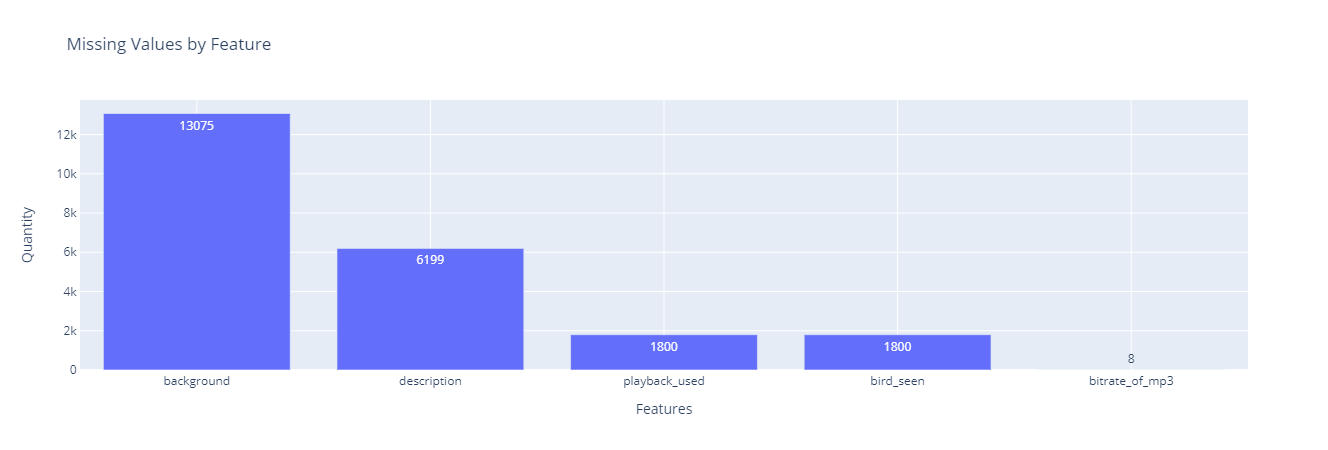

In [4]:
missing = train.isna().sum().sort_values(ascending=False)
missing = missing[missing != 0]
xp.bar(x=missing.index, y=missing, text=missing, title='Missing Values by Feature', labels={'x':'Features', 'y':'Quantity'})

- No relevant data missing

## Species
Distribution of bird species

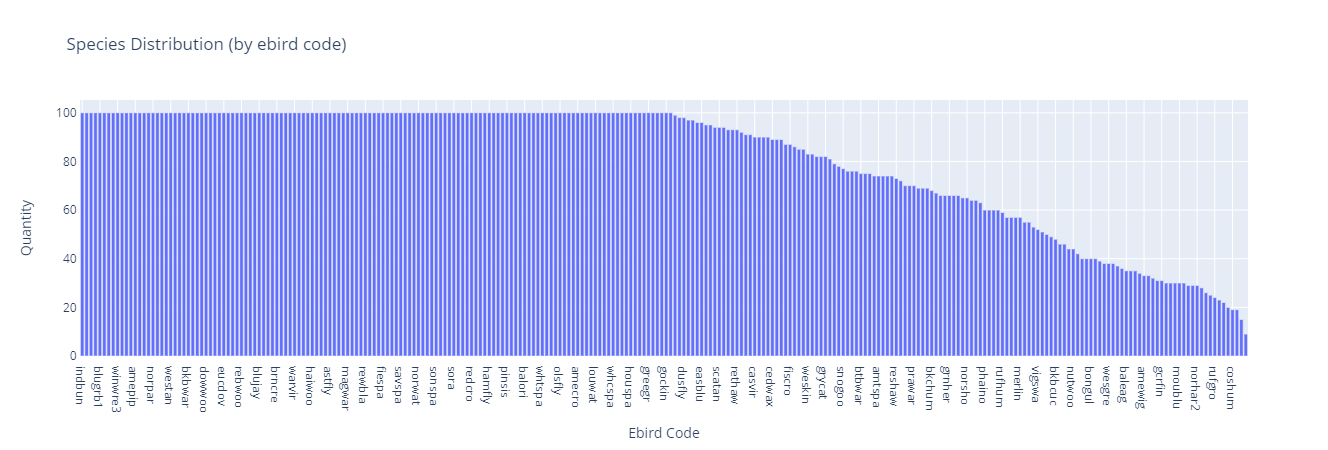

In [5]:
counts = train['ebird_code'].value_counts()
xp.bar(x=counts.index, y=counts, title='Species Distribution (by ebird code)', labels={'x':'Ebird Code', 'y':'Quantity'})

- Exactly 100 samples for about half of species in question
- Redhead is minimum at 9 samples
- Stats below

In [6]:
counts.describe()[['mean', 'std']].append(pd.Series(counts.var(), index=['var']))

mean     80.965909
std      25.776953
var     664.451305
dtype: float64

## Date and Time
Recording Date Distribution

In [7]:
# split datetime into separate dataframe
datetime = train[['date', 'time']]
datetime.date = pd.to_datetime(datetime.date, errors='coerce').dropna()
datetime['hour'] = pd.to_numeric(datetime.time.str.split(':', expand=True)[0], errors='coerce')

In [8]:
ax1 = datetime.date.value_counts().sort_values().plot(figsize=(10,6), title='Recordings by Date')
ax1.set_xlabel('Date')
ax1.set_ylabel('Quantity')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

- Majority of recordings taken in the past decade
- Interesting spike around 2003
- Cyclical spikes after 2013

In [9]:
ax2 = datetime['hour'].value_counts().sort_index().plot(figsize=(10,6), title='Recordings by Time', kind='bar', figure=plt.figure())
ax2.set_xlabel('Hour')
ax2.set_ylabel('Quantity')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

- Most recordings taken between 6AM and 12PM
- Gradual decrease as the day moves on from 8AM

## Location

### Country Distribution

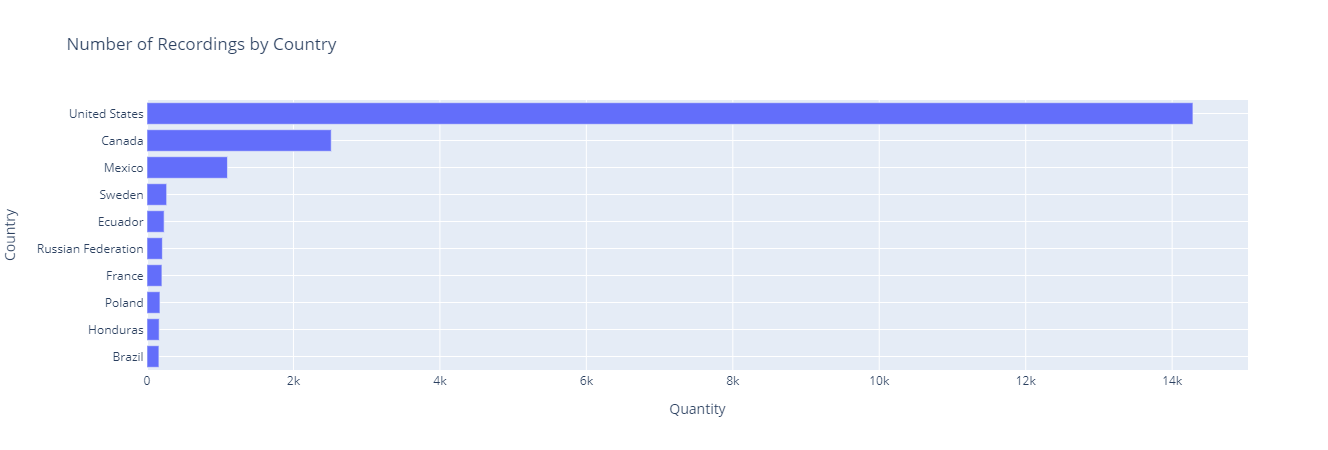

In [10]:
counts = train['country'].value_counts().sort_values(ascending=False).head(10).sort_values()
xp.bar(y=counts.index, x=counts, title='Number of Recordings by Country', labels={'y':'Country', 'x':'Quantity'}, orientation='h')

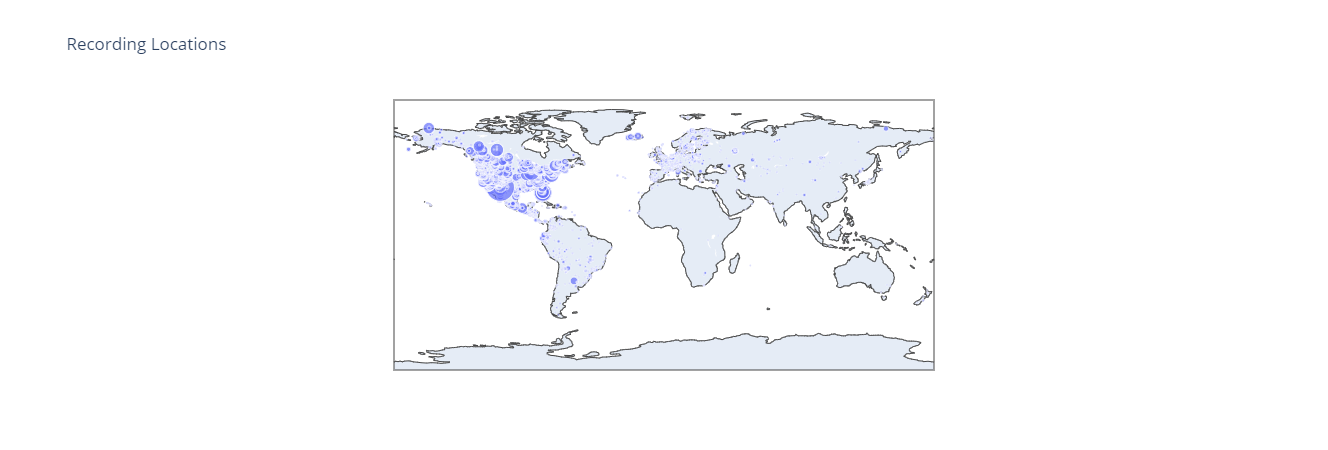

In [11]:
coords = train.groupby(['latitude', 'longitude'], as_index=False)['ebird_code'].agg('count')
coords = coords[coords.latitude != 'Not specified']
coords = coords[coords.longitude != 'Not specified']
xp.scatter_geo(lat=coords['latitude'], lon=coords['longitude'], title='Recording Locations', size=coords['ebird_code'])

- Vast majority of data comes from North America, specifically from USA